In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, AveragePooling2D, Dropout
from tensorflow.python.training import optimizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

import pandas as pd
import numpy as np
import PIL
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
train_df = pd.read_csv('train_ship_segmentations_v2.csv', index_col=0)

df = pd.read_csv('train_ship_segmentations_v2.csv')
df = df.drop_duplicates(subset='ImageId').fillna(0).rename(columns={"EncodedPixels": "HasShip"})
df.loc[(df.HasShip != 0), 'HasShip'] = 1
df.head()

,ImageId,HasShip
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
8,0001b1832.jpg,0


In [6]:
def load_img(filename, shape = (768, 768)):
    """
    gets np.array in rgb rofmat for filename
    """
    img = np.array(PIL.Image.open(r"C:/Airbus-ship-segm/train_v2/"+filename).resize(shape))
    return img

In [7]:
def get_mask(img_name):
    """
    input: img_name as a string
    output: mask as a np.array(768,768)
    """
    rle = [int(x) for x in " ".join(train_df[train_df.index.isin([img_name])]['EncodedPixels'].values).split()]
    rle_pairs= [[rle[i], rle[i+1]] for i in range(0,len(rle),2)]
    pixels = [(pix_pos%768, pix_pos//768) for start,length in rle_pairs for pix_pos in range(start,start+length)]
    mask = np.zeros((768,768))
    mask[tuple(zip(*pixels))] = 1
    return mask

In [8]:
IMG_WIDTH = 768
IMG_HEIGHT = 768
IMG_CHANNELS = 3
image_shape=(768, 768)

In [9]:
random.seed(2)
train_ids = random.sample(list(df.loc[df['HasShip'] == 1]['ImageId'].values), 1600)
train_ids, test_ids = train_test_split(train_ids, test_size=0.3, random_state=42)

In [10]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_) #y boolean for fitting model
y_true = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_) #y (0,1) for evaluating model

In [12]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = load_img(id_, (IMG_HEIGHT, IMG_WIDTH))/255
    X_train[n] = img
    mask = get_mask(id_)
    mask = mask == 1
    y_train[n] = mask.reshape(768,768,1)

100%|██████████████████████████████████████████████████████████████████████████████| 1120/1120 [00:38<00:00, 29.08it/s]


In [13]:
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = load_img(id_, (IMG_HEIGHT, IMG_WIDTH))/255
    X_test[n] = img
    mask = get_mask(id_)
    y_true[n] = mask.reshape(768,768,1)
    mask = mask == 1
    y_test[n] = mask.reshape(768,768,1)

100%|████████████████████████████████████████████████████████████████████████████████| 480/480 [00:17<00:00, 28.10it/s]


In [25]:
inputs = Input(shape=(768,768,3))
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv0 = BatchNormalization()(conv0)
conv0 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
conv0 = BatchNormalization()(conv0)

comp0 = AveragePooling2D((6,6))(conv0)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(comp0)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.4)(conv1)

pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.4)(conv2)

pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.4)(conv3)

pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.4)(conv4)

pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

upcv6 = UpSampling2D(size=(2,2))(conv5)
upcv6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv6)
upcv6 = BatchNormalization()(upcv6)
mrge6 = concatenate([conv4, upcv6], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge6)
conv6 = BatchNormalization()(conv6)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
conv6 = BatchNormalization()(conv6)


upcv7 = UpSampling2D(size=(2,2))(conv6)
upcv7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv7)
upcv7 = BatchNormalization()(upcv7)
mrge7 = concatenate([conv3, upcv7], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge7)
conv7 = BatchNormalization()(conv7)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upcv8 = UpSampling2D(size=(2,2))(conv7)
upcv8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv8)
upcv8 = BatchNormalization()(upcv8)
mrge8 = concatenate([conv2, upcv8], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge8)
conv8 = BatchNormalization()(conv8)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv8 = BatchNormalization()(conv8)

upcv9 = UpSampling2D(size=(2,2))(conv8)
upcv9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upcv9)
upcv9 = BatchNormalization()(upcv9)
mrge9 = concatenate([conv1, upcv9], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge9)
conv9 = BatchNormalization()(conv9)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = BatchNormalization()(conv9)

dcmp10 = UpSampling2D((6,6), interpolation='bilinear')(conv9)
mrge10 = concatenate([dcmp10, conv0], axis=3)
conv10 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(mrge10)
conv10 = BatchNormalization()(conv10)
conv10 = Conv2D(8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)
conv10 = BatchNormalization()(conv10)
conv11 = Conv2D(1, 1, activation='sigmoid')(conv10)


In [26]:
model = Model(inputs=inputs, outputs=conv11)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
model.fit(X_train, y_train, validation_split=0.1, batch_size=10, epochs = 15, verbose=2)

Epoch 1/15
101/101 - 1379s - loss: 0.6163 - val_loss: 0.5213 - 1379s/epoch - 14s/step
Epoch 2/15
101/101 - 6908s - loss: 0.4109 - val_loss: 0.7585 - 6908s/epoch - 68s/step
Epoch 3/15
101/101 - 24059s - loss: 0.2331 - val_loss: 0.8602 - 24059s/epoch - 238s/step
Epoch 4/15
101/101 - 1379s - loss: 0.1293 - val_loss: 0.0996 - 1379s/epoch - 14s/step
Epoch 5/15
101/101 - 1267s - loss: 0.0787 - val_loss: 0.0629 - 1267s/epoch - 13s/step
Epoch 6/15
101/101 - 1271s - loss: 0.0528 - val_loss: 0.0440 - 1271s/epoch - 13s/step
Epoch 7/15
101/101 - 1260s - loss: 0.0385 - val_loss: 0.0323 - 1260s/epoch - 12s/step
Epoch 8/15
101/101 - 13310s - loss: 0.0304 - val_loss: 0.0281 - 13310s/epoch - 132s/step
Epoch 9/15
101/101 - 1133s - loss: 0.0250 - val_loss: 0.0220 - 1133s/epoch - 11s/step
Epoch 10/15
101/101 - 1206s - loss: 0.0214 - val_loss: 0.0223 - 1206s/epoch - 12s/step
Epoch 11/15
101/101 - 1561s - loss: 0.0195 - val_loss: 0.0210 - 1561s/epoch - 15s/step
Epoch 12/15
101/101 - 1137s - loss: 0.0169 - v

In [14]:
model = load_model('models/ship_segment_model.h5')     # the same model as shown above

In [29]:
pred = model.predict(x=X_test, batch_size=10, verbose=2)

48/48 - 72s - 72s/epoch - 1s/step


In [43]:
pred_eval=pred.flatten()
for i in range(len(pred_eval)):
    if pred_eval[i] > 0.5:
        pred_eval[i]=1 

In [45]:
def dice(pred, targs):
    #pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [46]:
dice(pred_eval, y_true)

0.27838859217888107

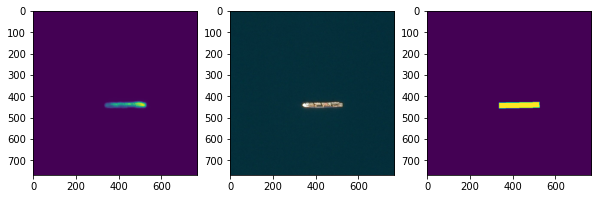

In [42]:
_, ax = plt.subplots(1, 3, figsize=(10, 10)) 
ax[0].imshow(pred[50])
ax[1].imshow(X_test[50])
ax[2].imshow(y_test[50])

In [47]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_true, pred_eval)
m.result().numpy()

0.65530354